# Cosine Angle Computation for MTI

In [1]:
# LOCATION
from pyfrac.imaging.kirchhoff import Kirchhoff

from pyfrac.visualisation.plotting_support import explode_volume

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import os
import matplotlib.pyplot as plt
import scipy as sp
from scipy.linalg import lstsq
from obspy.imaging.beachball import beachball
from obspy.imaging.beachball import beach

from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy.linalg import lstsq

import pylops
from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.optimization.sparsity  import *


In [3]:
def read_seis(seisfile, nr):
    # s_wave_file = os.path.join(data_path,'test.bin.curl')
    seis_flat = np.loadtxt(seisfile)

    # determine number of timesamples and ensure it saved fully
    nt = int(seis_flat.shape[0] / nr)
    try:
        seis_flat.reshape((nr, nt))
    except:
        print('Not good dims \n nt:%i nr:%i \n vz flat:%i' % (nt, nr, seis_flat.shape[0]))

    # Resample to 2D
    seis = seis_flat[:nt * nr].reshape((nr, nt))
    return seis

# Model Params & Data Loading

In [4]:
nr = 210
dt = 1e-3

dx = dy = dz = 10.
nx, nz, ny = [170, 150, 174]
x, y, z = np.arange(nx)*dx, np.arange(ny)*dy, np.arange(nz)*dz

vp = 4370
vel = vp * np.ones([nx, ny, nz])

In [178]:
seispath = '/home/birniece/Documents/Projects/MicroseismicModelling/MicroseismicProcessing/FDModelling/UTAH_Homo_tst/outputs/su'
expname = 'UTAH_Homo_tst'
vz = read_seis(os.path.join(seispath,'%s_vy.txt'%expname), nr)  # y=z in SOFI


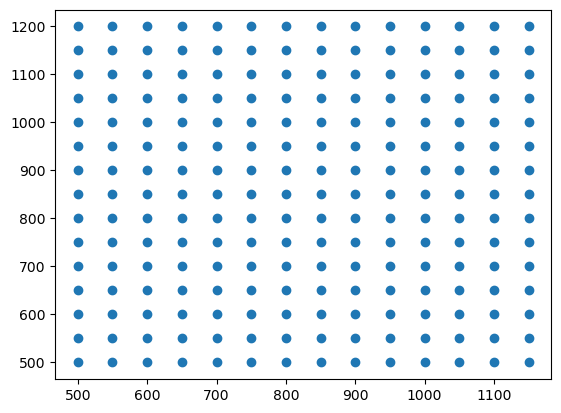

In [6]:
recs = np.loadtxt('/home/birniece/Documents/data/UTAH_FORGE/ClairesVMods/homo/receiver.dat').T
recs = np.array([recs[0],recs[2], recs[1]])
plt.scatter(recs[0],recs[1])

In [7]:
sx, sy, sz = 850, 860, 1300

In [8]:
recs.shape

(3, 210)

## COMPUTE TRAVELTIME - NR,NX,NY,NZ

In [9]:
# TRAVEL TIME TABLE
trav = Kirchhoff._traveltime_table(z, 
                                   x, 
                                   y=y, 
                                   recs=recs, 
                                   srcs=recs[:,:1], 
                                   vel=vel, 
                                   mode='eikonal')[1]

In [10]:
TTT_full = trav.reshape(nx,ny,nz,nr).transpose([3,0,1,2])

In [11]:
np.mean(TTT_full)

0.24778979633721182

(<Figure size 800x800 with 3 Axes>,
 (<Axes: xlabel='y samples', ylabel='x samples'>,
  <Axes: xlabel='z samples'>,
  <Axes: ylabel='z samples'>))

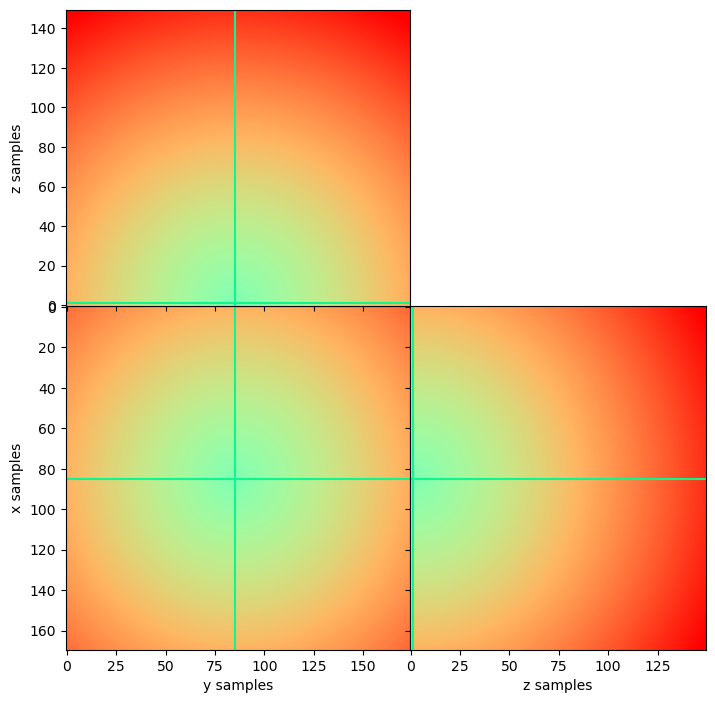

In [12]:
explode_volume(TTT_full[nr//2], 
               t=int(recs[0,nr//2]/dx), 
               x=int(recs[1,nr//2]/dy), 
               y=int(recs[2,nr//2]/dz),
               cmap='rainbow',
                   figsize=(8, 8), clipval=None, p=98,
                   tlim=None, xlim=None, ylim=None,
                   tcrop=None, xcrop=None, ycrop=None,
                   labels=('[x]', '[y]', '[z]'),
                   tlabel='x', xlabel='y', ylabel='z',
                   ratio=None, linespec=None, interp=None, title='',
                   filename=None, save_opts=None)

# COLLECT NECESSARY INFORMATION FOR SOURCE LOCATIONS

- Traveltime Tables
- Take-off Angles
- Receiver Angles

# STRAIGHT RAY ASSUMPTION: SOURCE ANGLES = RECEIVER ANGLES



In [13]:
nc = 3  # number of axis components, for 3D then 3 < assumes geophones

gamma_sourceangles = np.zeros([nc, nr, nx, ny, nz])
dist_table = np.zeros([nr, nx, ny, nz])

for irec in range(nr):
    rx,ry,rz = recs[0, irec], recs[1, irec], recs[2, irec]
    
    s_locs_x, s_locs_y, s_locs_z = np.meshgrid(x, y, z, indexing='ij')

    # Compute 'distances'
    delta_x = s_locs_x - rx
    delta_y = s_locs_y - ry
    delta_z = s_locs_z - rz
    total_distance = np.sqrt(delta_x**2 + delta_y**2 + delta_z**2)
    dist_table[irec] = total_distance
    
    # cosine x
    gamma_sourceangles[0,irec] = delta_x / total_distance
    # cosine y
    gamma_sourceangles[1,irec] = delta_y / total_distance
    # cosine z
    gamma_sourceangles[2,irec] = delta_z / total_distance
    
    # At rec loc total distance is zero < CANT DIVIDE BY ZERO!
    rl = np.argwhere(total_distance==0)[0]
    gamma_sourceangles[:,irec,rl[0],rl[1],rl[2]] = 0

(<Figure size 800x800 with 3 Axes>,
 (<Axes: xlabel='x samples', ylabel='z samples'>,
  <Axes: xlabel='y samples'>,
  <Axes: ylabel='y samples'>))

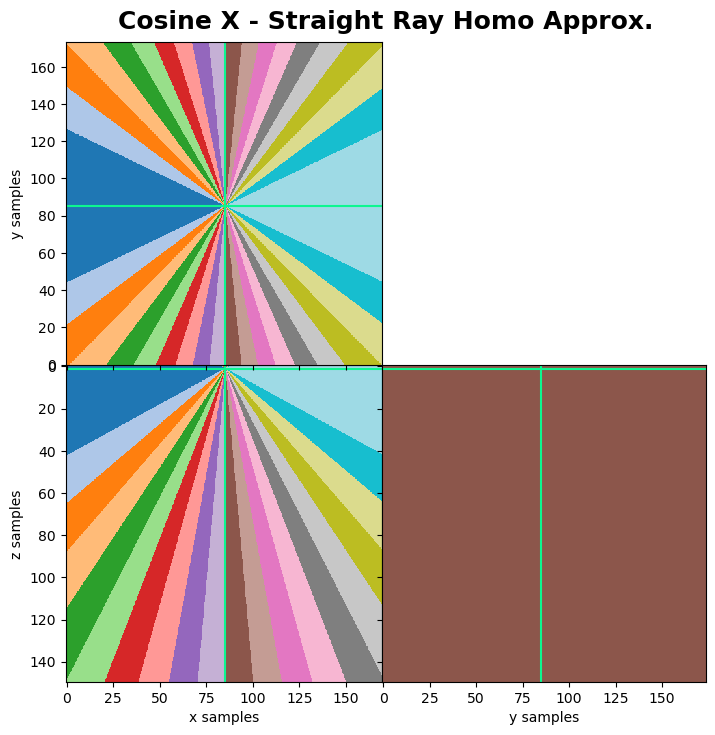

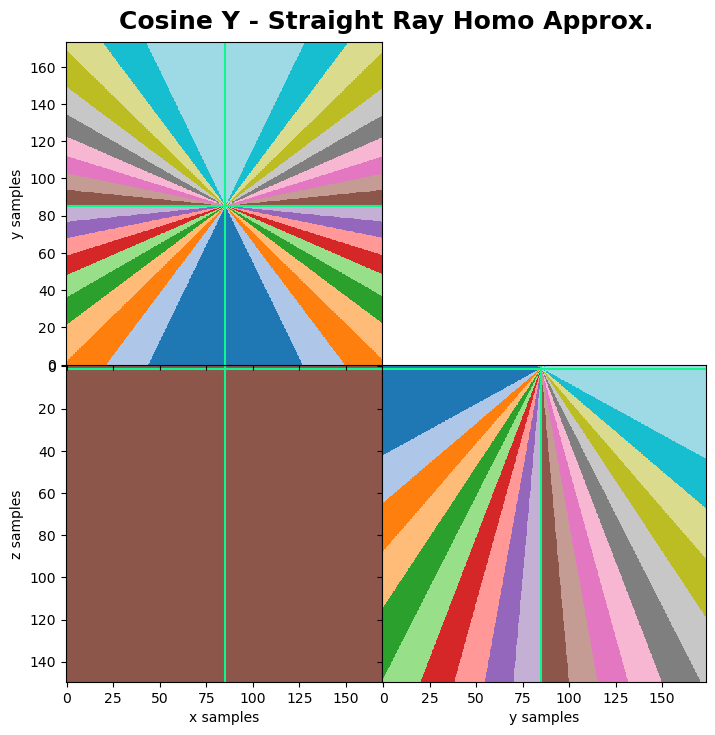

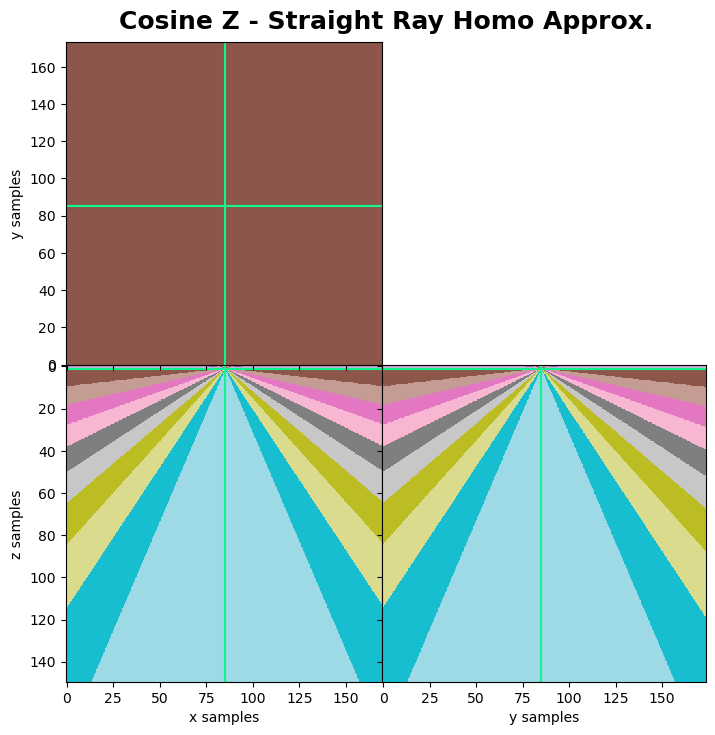

In [14]:
explode_volume(gamma_sourceangles[0,nr//2].transpose(2,0,1), 
               t=int(recs[2,nr//2]/dx), 
               x=int(recs[0,nr//2]/dy), 
               y=int(recs[1,nr//2]/dz),
               cmap='tab20',               
               clipval=[-1,1],
               labels=( '[z]', '[x]', '[y]',),
               tlabel='z', xlabel='x', ylabel='y',
               title='Cosine X - Straight Ray Homo Approx.',
               )
explode_volume(gamma_sourceangles[1,nr//2].transpose(2,0,1), 
               t=int(recs[2,nr//2]/dx), 
               x=int(recs[0,nr//2]/dy), 
               y=int(recs[1,nr//2]/dz),
               cmap='tab20',               
               clipval=[-1,1],
               labels=( '[z]', '[x]', '[y]',),
               tlabel='z', xlabel='x', ylabel='y',
               title='Cosine Y - Straight Ray Homo Approx.',
               )
explode_volume(gamma_sourceangles[2,nr//2].transpose(2,0,1), 
               t=int(recs[2,nr//2]/dx), 
               x=int(recs[0,nr//2]/dy), 
               y=int(recs[1,nr//2]/dz),
               cmap='tab20',               
               clipval=[-1,1],
               labels=( '[z]', '[x]', '[y]',),
               tlabel='z', xlabel='x', ylabel='y',
               title='Cosine Z - Straight Ray Homo Approx.',
               )

(<Figure size 800x800 with 3 Axes>,
 (<Axes: xlabel='y samples', ylabel='x samples'>,
  <Axes: xlabel='z samples'>,
  <Axes: ylabel='z samples'>))

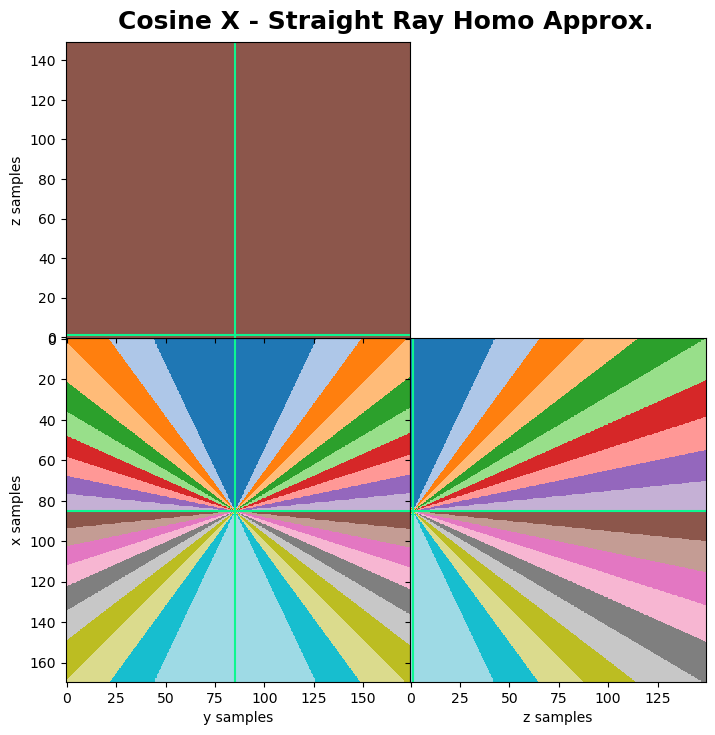

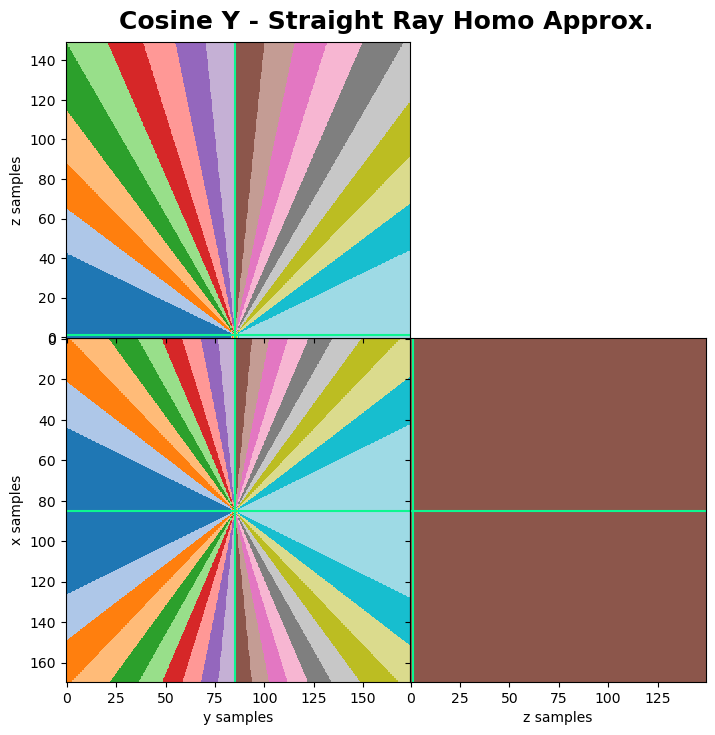

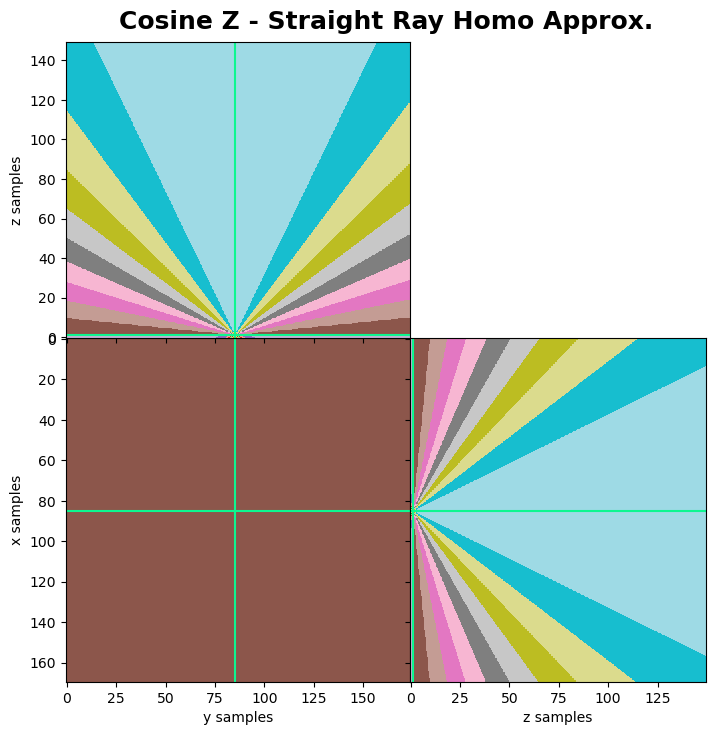

In [15]:
explode_volume(gamma_sourceangles[0,nr//2], 
               t=int(recs[0,nr//2]/dx), 
               x=int(recs[1,nr//2]/dy), 
               y=int(recs[2,nr//2]/dz),
               cmap='tab20',               
               clipval=[-1,1],
               figsize=(8, 8),
               labels=('[x]', '[y]', '[z]'),
               tlabel='x', xlabel='y', ylabel='z',
               title='Cosine X - Straight Ray Homo Approx.',
               )

explode_volume(gamma_sourceangles[1,nr//2], 
               t=int(recs[0,nr//2]/dx), 
               x=int(recs[1,nr//2]/dy), 
               y=int(recs[2,nr//2]/dz),
               cmap='tab20',               
               clipval=[-1,1],
               figsize=(8, 8),
               labels=('[x]', '[y]', '[z]'),
               tlabel='x', xlabel='y', ylabel='z',
               title='Cosine Y - Straight Ray Homo Approx.',)

explode_volume(gamma_sourceangles[2,nr//2], 
               t=int(recs[0,nr//2]/dx), 
               x=int(recs[1,nr//2]/dy), 
               y=int(recs[2,nr//2]/dz),
               cmap='tab20',               
               clipval=[-1,1],
               figsize=(8, 8),
               labels=('[x]', '[y]', '[z]'),
               tlabel='x', xlabel='y', ylabel='z',
               title='Cosine Z - Straight Ray Homo Approx.',
               )

# GET P-WAVE AMPLITUDES

In [179]:
vz_shft = vz.copy() # Accounting for ignition time
vz_shft.shape

(210, 1000)

In [180]:
sofi_shift = 50
source_times = sofi_shift+np.round(TTT_full[:,int(sx//dx),int(sy//dy),int(sz//dz)]/dt).astype(int)
source_times

array([366, 364, 361, 359, 358, 357, 356, 356, 356, 357, 358, 359, 361,
       364, 364, 361, 358, 356, 355, 354, 353, 353, 353, 354, 355, 356,
       358, 361, 361, 358, 356, 354, 352, 351, 350, 350, 350, 351, 352,
       354, 356, 358, 359, 356, 354, 352, 350, 349, 348, 348, 348, 349,
       350, 352, 354, 356, 357, 355, 352, 350, 349, 347, 347, 346, 347,
       347, 349, 350, 352, 355, 356, 353, 351, 349, 347, 346, 345, 345,
       345, 346, 347, 349, 351, 353, 355, 353, 350, 348, 346, 345, 345,
       344, 345, 345, 346, 348, 350, 353, 355, 352, 350, 348, 346, 345,
       344, 344, 344, 345, 346, 348, 350, 352, 355, 352, 350, 348, 346,
       345, 344, 344, 344, 345, 346, 348, 350, 352, 356, 353, 351, 349,
       347, 346, 345, 345, 345, 346, 347, 349, 351, 353, 357, 354, 352,
       350, 348, 347, 346, 346, 346, 347, 348, 350, 352, 354, 358, 356,
       353, 351, 350, 348, 348, 347, 348, 348, 350, 351, 353, 356, 360,
       357, 355, 353, 351, 350, 350, 349, 350, 350, 351, 353, 35

In [181]:
np.min(source_times)

344

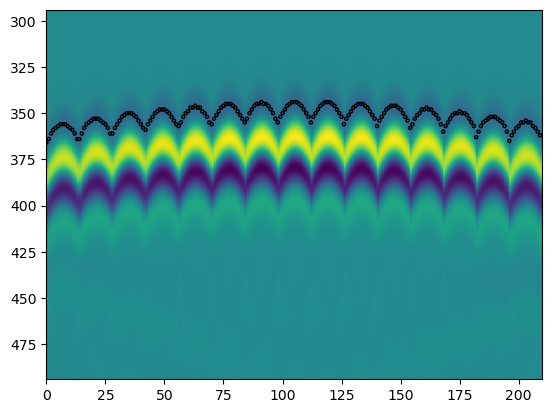

In [182]:
plt.imshow(vz_shft[:,np.min(source_times)-50:150+np.min(source_times)].T, aspect='auto',
           extent=[0, nr, 150+np.min(source_times), np.min(source_times)-50]
          )
plt.scatter(range(nr),source_times, marker='o', facecolors='none', edgecolors='k', s=5)
# plt.scatter(range(nr),np.argmax(abs(vz_shft[:,:500]),axis=1), marker='o', facecolors='none', edgecolors='k')

In [183]:
vz_amps = np.ones(nr)
for i in range(nr):
    vz_amps[i] = vz_shft[i,source_times[i]]
# vz_amps = vz_amps/np.max(abs(vz_amps))

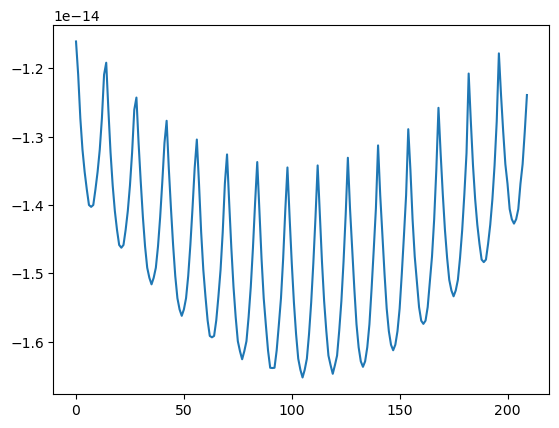

In [184]:
plt.plot(vz_amps)

# MTI - ACTUAL IMPLEMENTATION

## Make Greens Matrix [6 x nr]

Rows correspond to the six elements of which the different MT components are multiplied by FOR A SINGLE RECEIVER

In [185]:
# Pre-make dictionary of the MT components values 
MT_comp_dict = [{'elementID':0, 'laymans':'xx', 'pq':[0,0], 'ODscaler':1, 'MCweighting':1},
                {'elementID':1, 'laymans':'yy', 'pq':[1,1], 'ODscaler':1, 'MCweighting':1},
                {'elementID':2, 'laymans':'zz', 'pq':[2,2], 'ODscaler':1, 'MCweighting':1},
                {'elementID':3, 'laymans':'xy', 'pq':[0,1], 'ODscaler':2, 'MCweighting':1},
                {'elementID':4, 'laymans':'xz', 'pq':[0,2], 'ODscaler':2, 'MCweighting':1},
                {'elementID':5, 'laymans':'yz', 'pq':[1,2], 'ODscaler':2, 'MCweighting':1},
               ]

'''
elementID < indicing style
laymans < MT component in seismic terminology
pq < indices of the two component parameters
ODscaler < off-diagonal scaler, allows multiplication of OD elements by 2 so can work on 6 MT components as opposed to 9
MCweighting < for weighting MC component importance [TO-DO]
'''

'\nelementID < indicing style\nlaymans < MT component in seismic terminology\npq < indices of the two component parameters\nODscaler < off-diagonal scaler, allows multiplication of OD elements by 2 so can work on 6 MT components as opposed to 9\nMCweighting < for weighting MC component importance [TO-DO]\n'

VARIABLE TO USE
- gamma_sourceangles 
- dist_table 

In [186]:
# Components used by all 
omega_p = 20  # Assume central frequency of 25Hz
alpha = np.mean(vel) 

all_scaler = omega_p/(4*np.pi * alpha**3)

In [187]:
# SLICE ON SOURCE LOC
sloc_ind = [int(sx//dx), int(sy//dy), int(sz//dz)]  # x,y,z indices of source location
dist_sloc = dist_table[:, sloc_ind[0],sloc_ind[1],sloc_ind[2]]
gamma_sloc = gamma_sourceangles[:, :, sloc_ind[0],sloc_ind[1],sloc_ind[2]]

In [188]:
G_z = np.zeros([6,nr]) # Z-component
zcomp_gamma_ind = 2  # Gamma index related to 
for irec in range(nr):
    for cmp_dict in MT_comp_dict:
        el_indic = cmp_dict['elementID']
        p_gamma_ind, q_gamma_ind = cmp_dict['pq']
        
        gamma_elements = gamma_sloc[zcomp_gamma_ind,irec] * gamma_sloc[p_gamma_ind,irec] * gamma_sloc[q_gamma_ind,irec] 
        
        G_z[el_indic,irec] = all_scaler * gamma_elements * dist_sloc[irec]**-1 
        # print(el_indic, el_p, el_q)

In [189]:
G_z.shape

(6, 210)

# TESTING ON FD Data

In [190]:
u_zp_FD = vz_amps
MT_ls_FD, _, _, _  = lstsq(G_z.T, u_zp_FD)

In [191]:
MT_ls_FD

array([ 9.30689306e-01,  1.61431716e-01, -1.11598222e+00, -6.56116338e-04,
       -6.88861953e-04, -3.19911130e-04])

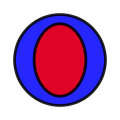

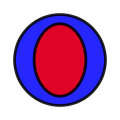

In [192]:
MT_BB_FD = MT_ls_FD.copy()
MT_BB_FD[0], MT_BB_FD[2] = MT_BB_FD[2], MT_BB_FD[0]
MT_BB_FD[5] = MT_BB_FD[3]
MT_BB_FD[3] = MT_BB_FD[4]
beachball(MT_BB_FD, linewidth=2, alpha=0.85, width=150, xy=[sloc_ind[0]*dx,sloc_ind[1]*dy], bgcolor='r')

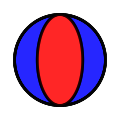

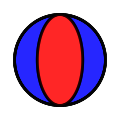

In [195]:
# FORWARD MODEL <- Inverse Crime
Mxx = 1
Myy = 0
Mzz = -1
Mxy = 0
Mxz = 0
Myz = 0
MTscale = 1/np.sqrt(3)

MT = MTscale * np.array([Mxx, Myy, Mzz, Mxy, Mxz, Myz])
u_zp = np.matmul(G_z.T, MT)

MT_BB = MT.copy()
MT_BB[0], MT_BB[2] = MT_BB[2], MT_BB[0]
MT_BB[5] = MT_BB[3]
MT_BB[3] = MT_BB[4]
beachball(MT_BB, linewidth=2, alpha=0.85, width=150, xy=[sloc_ind[0]*dx,sloc_ind[1]*dy], bgcolor='r')

In [196]:
u_zp = np.matmul(G_z.T, MT)
# BACKWARD LEAST SQUARES
MT_ls, res, rnk, s  = lstsq(G_z.T, u_zp)

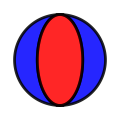

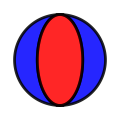

In [197]:
MT_BB_ls = MT_ls.copy()
MT_BB_ls[0], MT_BB_ls[2] = MT_BB_ls[2], MT_BB_ls[0]
MT_BB_ls[5] = MT_BB_ls[3]
MT_BB_ls[3] = MT_BB_ls[4]
beachball(MT_BB_ls, linewidth=2, alpha=0.85, width=150, xy=[sloc_ind[0]*dx,sloc_ind[1]*dy], bgcolor='r')

# SUMMARY FIGURE

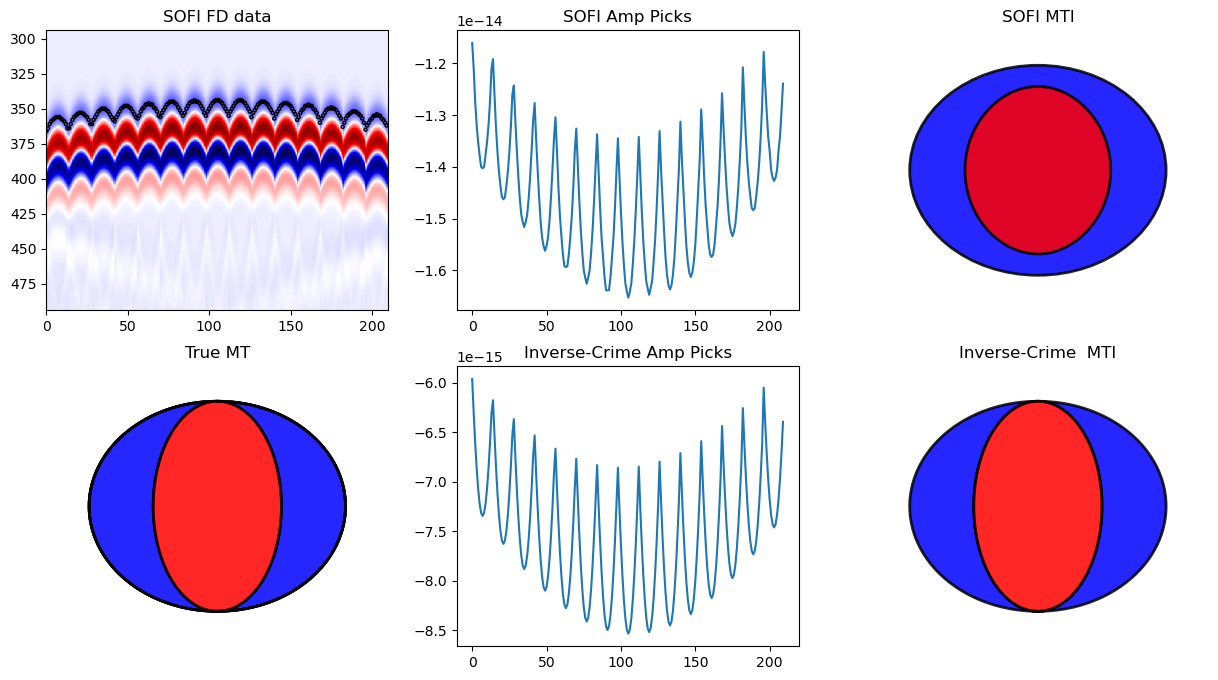

In [198]:
fig, axs =plt.subplots(2,3,figsize=[15,8])

axs[0,0].imshow(vz_shft[:,np.min(source_times)-50:150+np.min(source_times)].T, aspect='auto',
           extent=[0, nr, 150+np.min(source_times), np.min(source_times)-50], cmap='seismic'
          )
axs[0,0].scatter(range(nr),source_times, marker='o', facecolors='none', edgecolors='k', s=5)

b_ls = beach(MT_BB, linewidth=2, alpha=0.85, width=150, xy=[0,0], bgcolor='r')
axs[1,0].add_collection(b_ls) 

axs[0,1].plot(vz_amps)
axs[1,1].plot(u_zp)
b_fd = beach(MT_BB_FD, linewidth=2, alpha=0.85, width=150, xy=[0,0], bgcolor='r')
axs[0,2].add_collection(b_fd) 

b_ls = beach(MT_BB_ls, linewidth=2, alpha=0.85, width=150, xy=[0,0], bgcolor='r')
axs[1,2].add_collection(b_ls) 

axs[0,0].set_title('SOFI FD data')
axs[0,1].set_title('SOFI Amp Picks')
axs[0,2].set_title('SOFI MTI')

axs[1,0].set_title('True MT')
axs[1,1].set_title('Inverse-Crime Amp Picks')
axs[1,2].set_title('Inverse-Crime  MTI')

for ax in [axs[0,2], axs[1,0], axs[1,2]]: ax.axis('off'); ax.set_ylim([-100,100]); ax.set_xlim([-100,100])
plt.savefig('Sofi-MTI.png')